In [1]:
import ast
import os
import shutil

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import torch
from PIL import Image
from tensorflow import keras
from tqdm import tqdm

In [2]:
base_config = {
    "IMG_HEIGH": 600,
    "IMG_WIDTH": 600,
    "BATCH_SIZE": 16,
    "SEED": 42,
}
classes = {"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3}

In [3]:
train = pd.read_csv("/app/_data/train.csv")

In [4]:
# os.mkdir("/app/_data/train_npy/")

In [5]:
train["class_id"] = train["class"].replace(classes)

In [6]:
class Aug:
    def augment_image(img):
        h = img.shape[0]
        w = img.shape[1]
        transform = albumentations.Compose(
            [
                albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
                albumentations.OneOf(
                    [
                        albumentations.MotionBlur((3, 5)),
                        albumentations.MedianBlur(blur_limit=5),
                        albumentations.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                        albumentations.Blur(blur_limit=(3, 5)),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.GaussNoise(var_limit=[10, 20], mean=1),
                        albumentations.ImageCompression(
                            quality_lower=70, quality_upper=100, compression_type=1
                        ),
                        albumentations.MultiplicativeNoise(
                            multiplier=(0.95, 1.05), per_channel=False, elementwise=True
                        ),
                        albumentations.Downscale(
                            scale_min=0.8, scale_max=0.99, interpolation=4
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.RandomBrightnessContrast(
                            brightness_limit=0.2,
                            contrast_limit=0.2,
                            brightness_by_max=True,
                        ),
                        albumentations.augmentations.transforms.Sharpen(alpha=(0.05, 0.15), lightness=(0.5, 1.0),p=1),
                        albumentations.augmentations.transforms.RandomToneCurve(scale=0.15)
                    ],
                    p=0.2,
                ),
                albumentations.RandomSizedCrop(
                    min_max_height=(0.9 * h, 0.9 * w),
                    height=h,
                    width=w,
                    w2h_ratio=1.0,
                    interpolation=0,
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.OpticalDistortion(
                            distort_limit=0.1,
                            shift_limit=0.1,
                            border_mode=0,
                        ),
                        albumentations.ElasticTransform(
                            alpha=2.0,
                            sigma=2.0,
                            alpha_affine=2.0,
                            interpolation=0,
                            border_mode=0,
                        ),
                        albumentations.GridDistortion(
                            num_steps=5,
                            distort_limit=0.3,
                            interpolation=0,
                            border_mode=0,
                        ),
                    ],
                    p=0.3,
                ),
                albumentations.OneOf(
                    [
                        albumentations.Rotate(
                            limit=(-10, 10), interpolation=0, border_mode=0
                        ),
                        albumentations.ShiftScaleRotate(
                            shift_limit=0.1,
                            scale_limit=0.1,
                            rotate_limit=10,
                            interpolation=0,
                            border_mode=0,
                        ),
                        albumentations.augmentations.crops.transforms.CropAndPad(
                            px=None,
                            percent=(-0.15, 0.1),
                            pad_mode=0,
                            pad_cval=0,
                            pad_cval_mask=0,
                            keep_size=True,
                            sample_independently=True,
                            interpolation=1,
                        ),
                        albumentations.RandomSizedCrop(
                            min_max_height=(0.9 * h, 0.9 * w),
                            height=h,
                            width=w,
                            w2h_ratio=1.0,
                            interpolation=0,
                        )
                    ],
                    p=0.3,
                ),
            ]
        )

        return transform(image=img)["image"]

In [7]:
img = Image.open("/app/_data/jpg/" + os.listdir("/app/_data/jpg/")[88])
img= img.resize((600,600))
img = np.array(img)
# img.shape

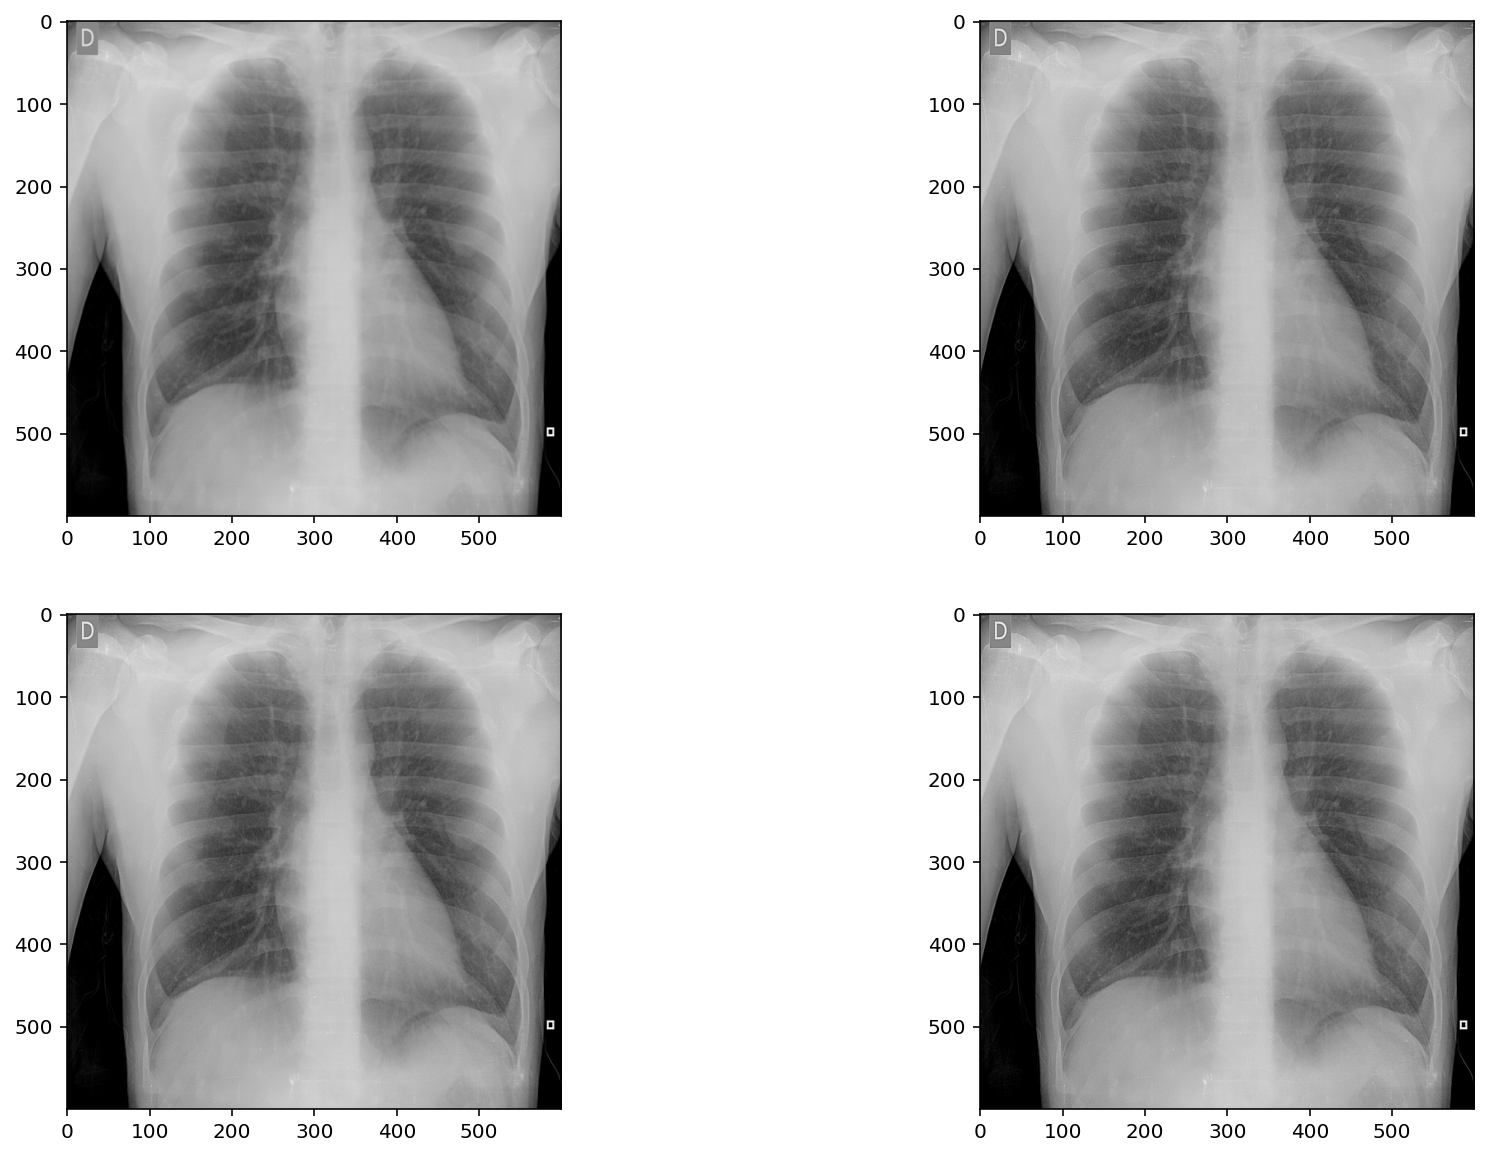

In [8]:
t = albumentations.Compose(
    [
        albumentations.augmentations.transforms.Sharpen(alpha=(0.05, 0.15), lightness=(0.5, 1.0),p=1)
    ]
)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.imshow(t(image=img)["image"])
plt.subplot(2, 2, 3)
plt.imshow(t(image=img)["image"])
plt.subplot(2, 2, 4)
plt.imshow(t(image=img)["image"])
plt.show();

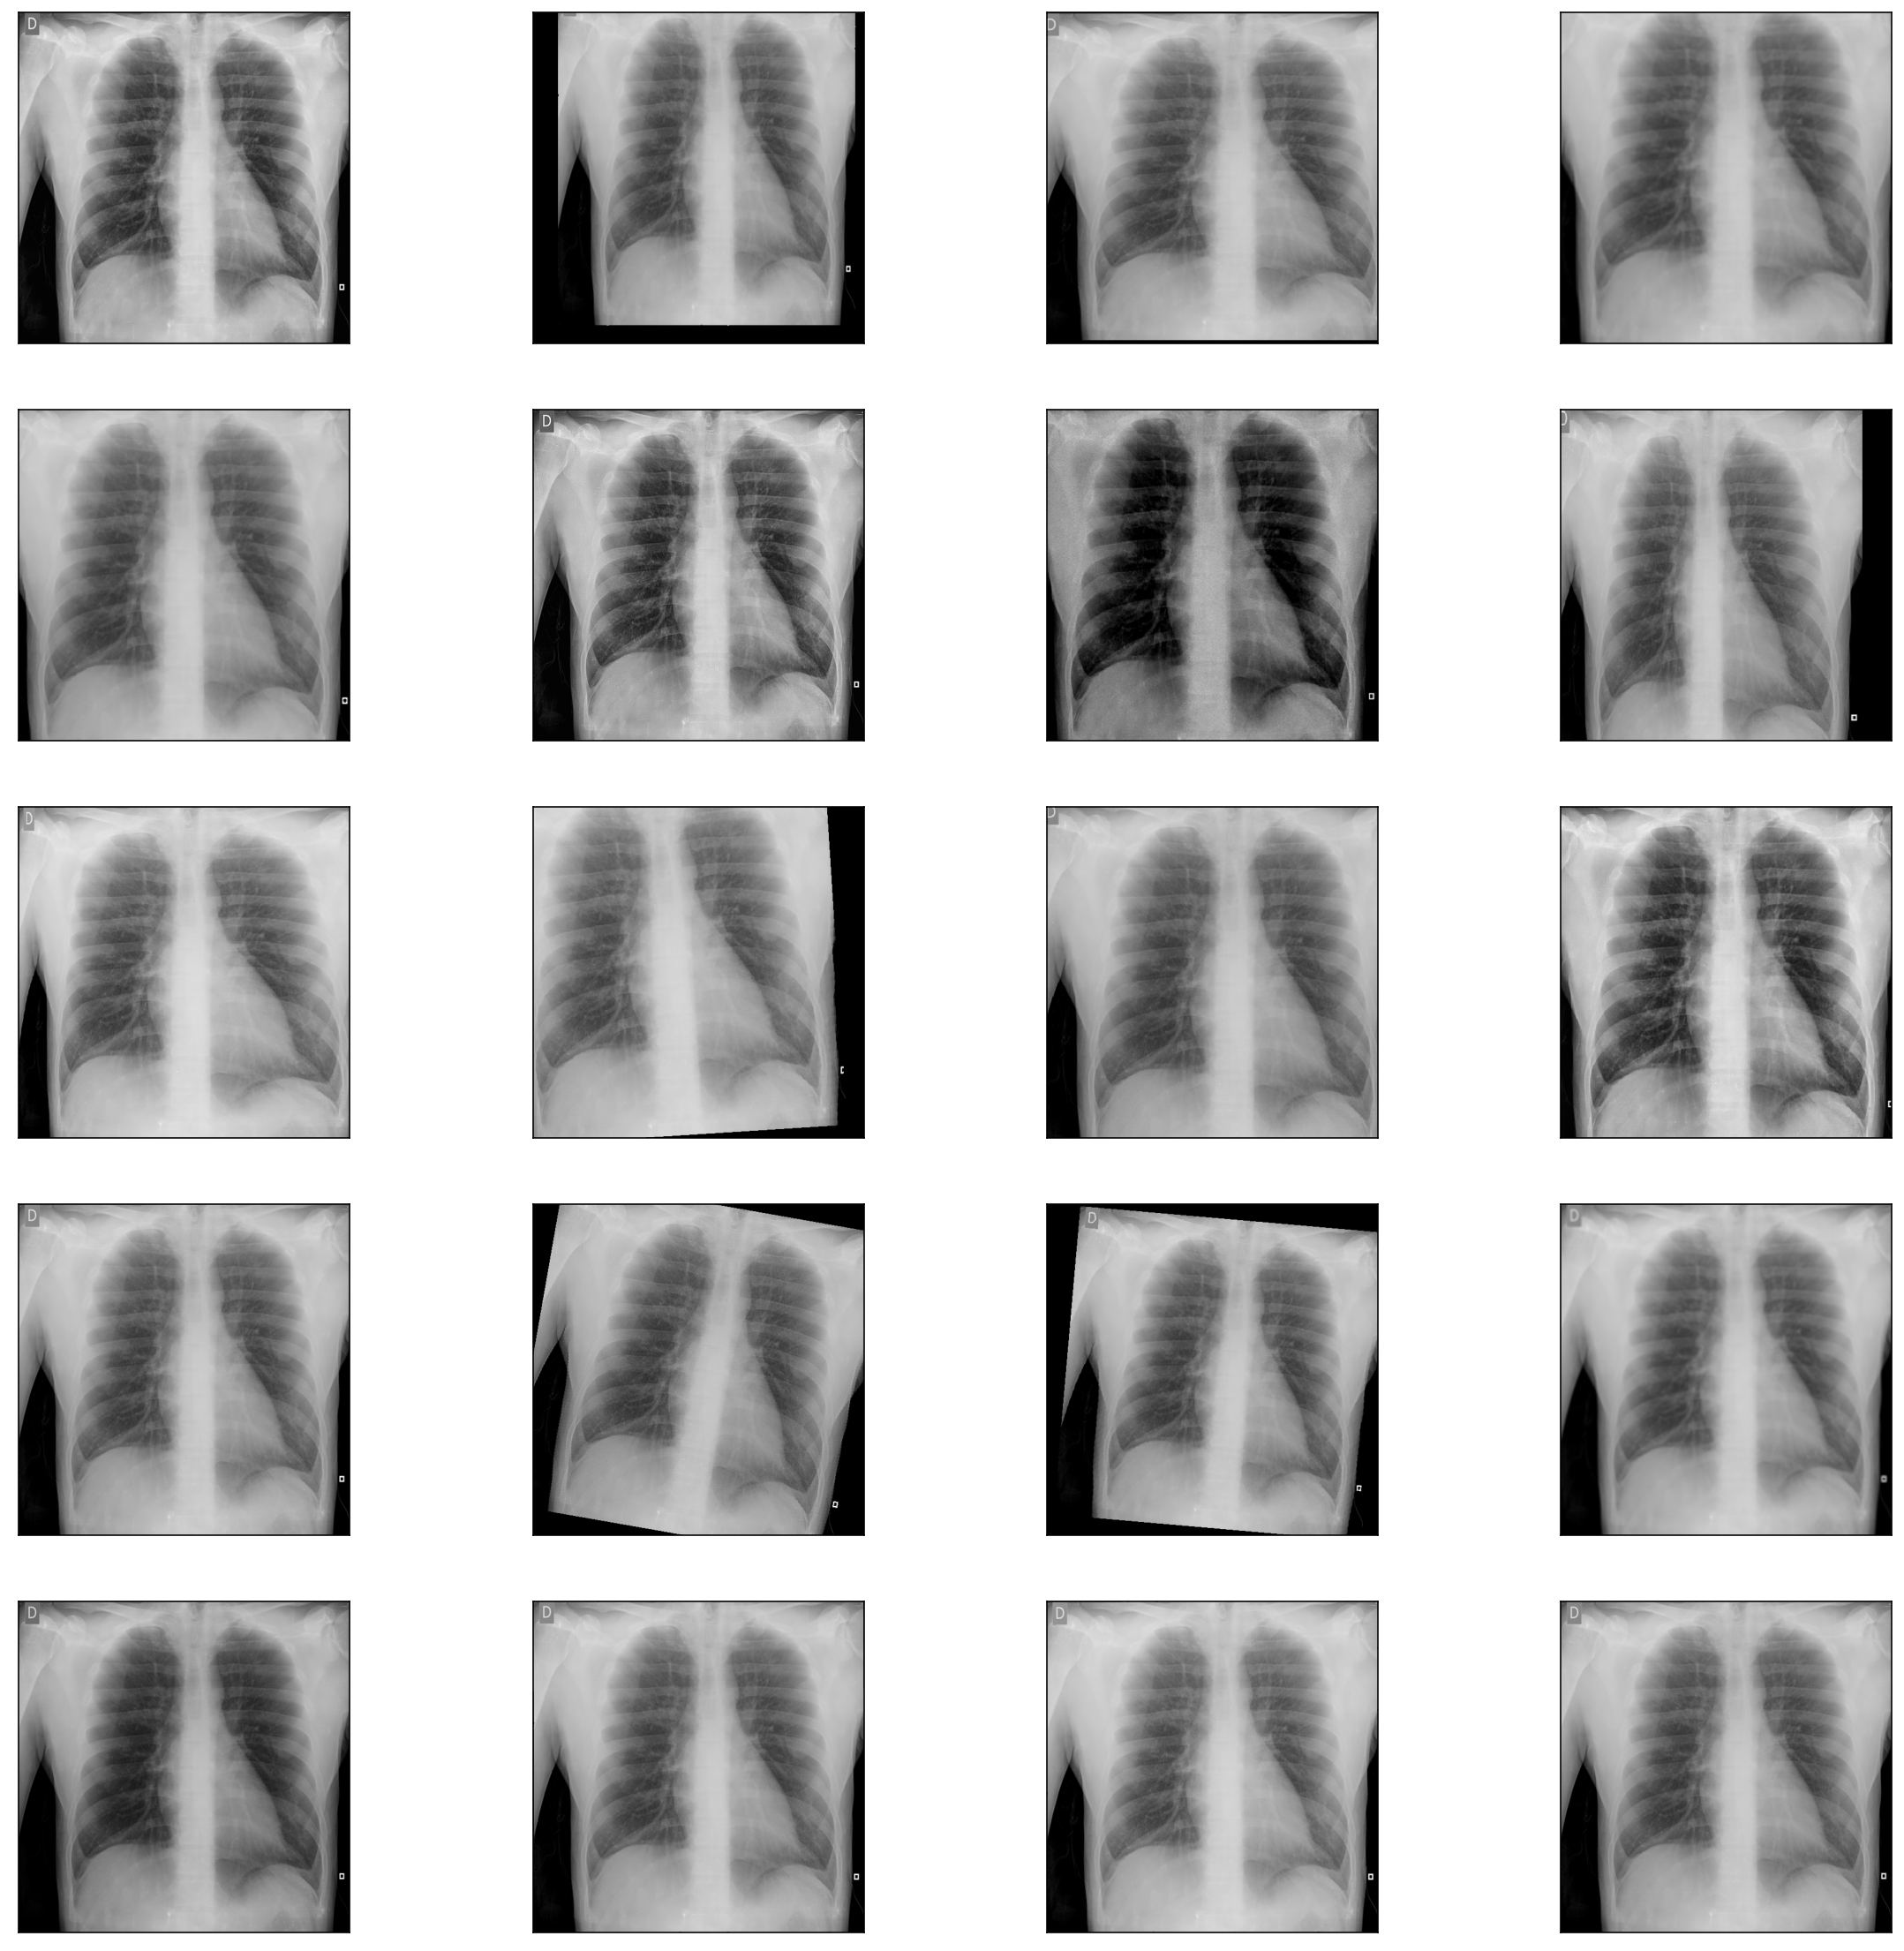

In [9]:
plt.figure(figsize=(20, 20))
for i in range(20):
    x = Aug.augment_image(img)
    plt.subplot(5, 4, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
plt.show()

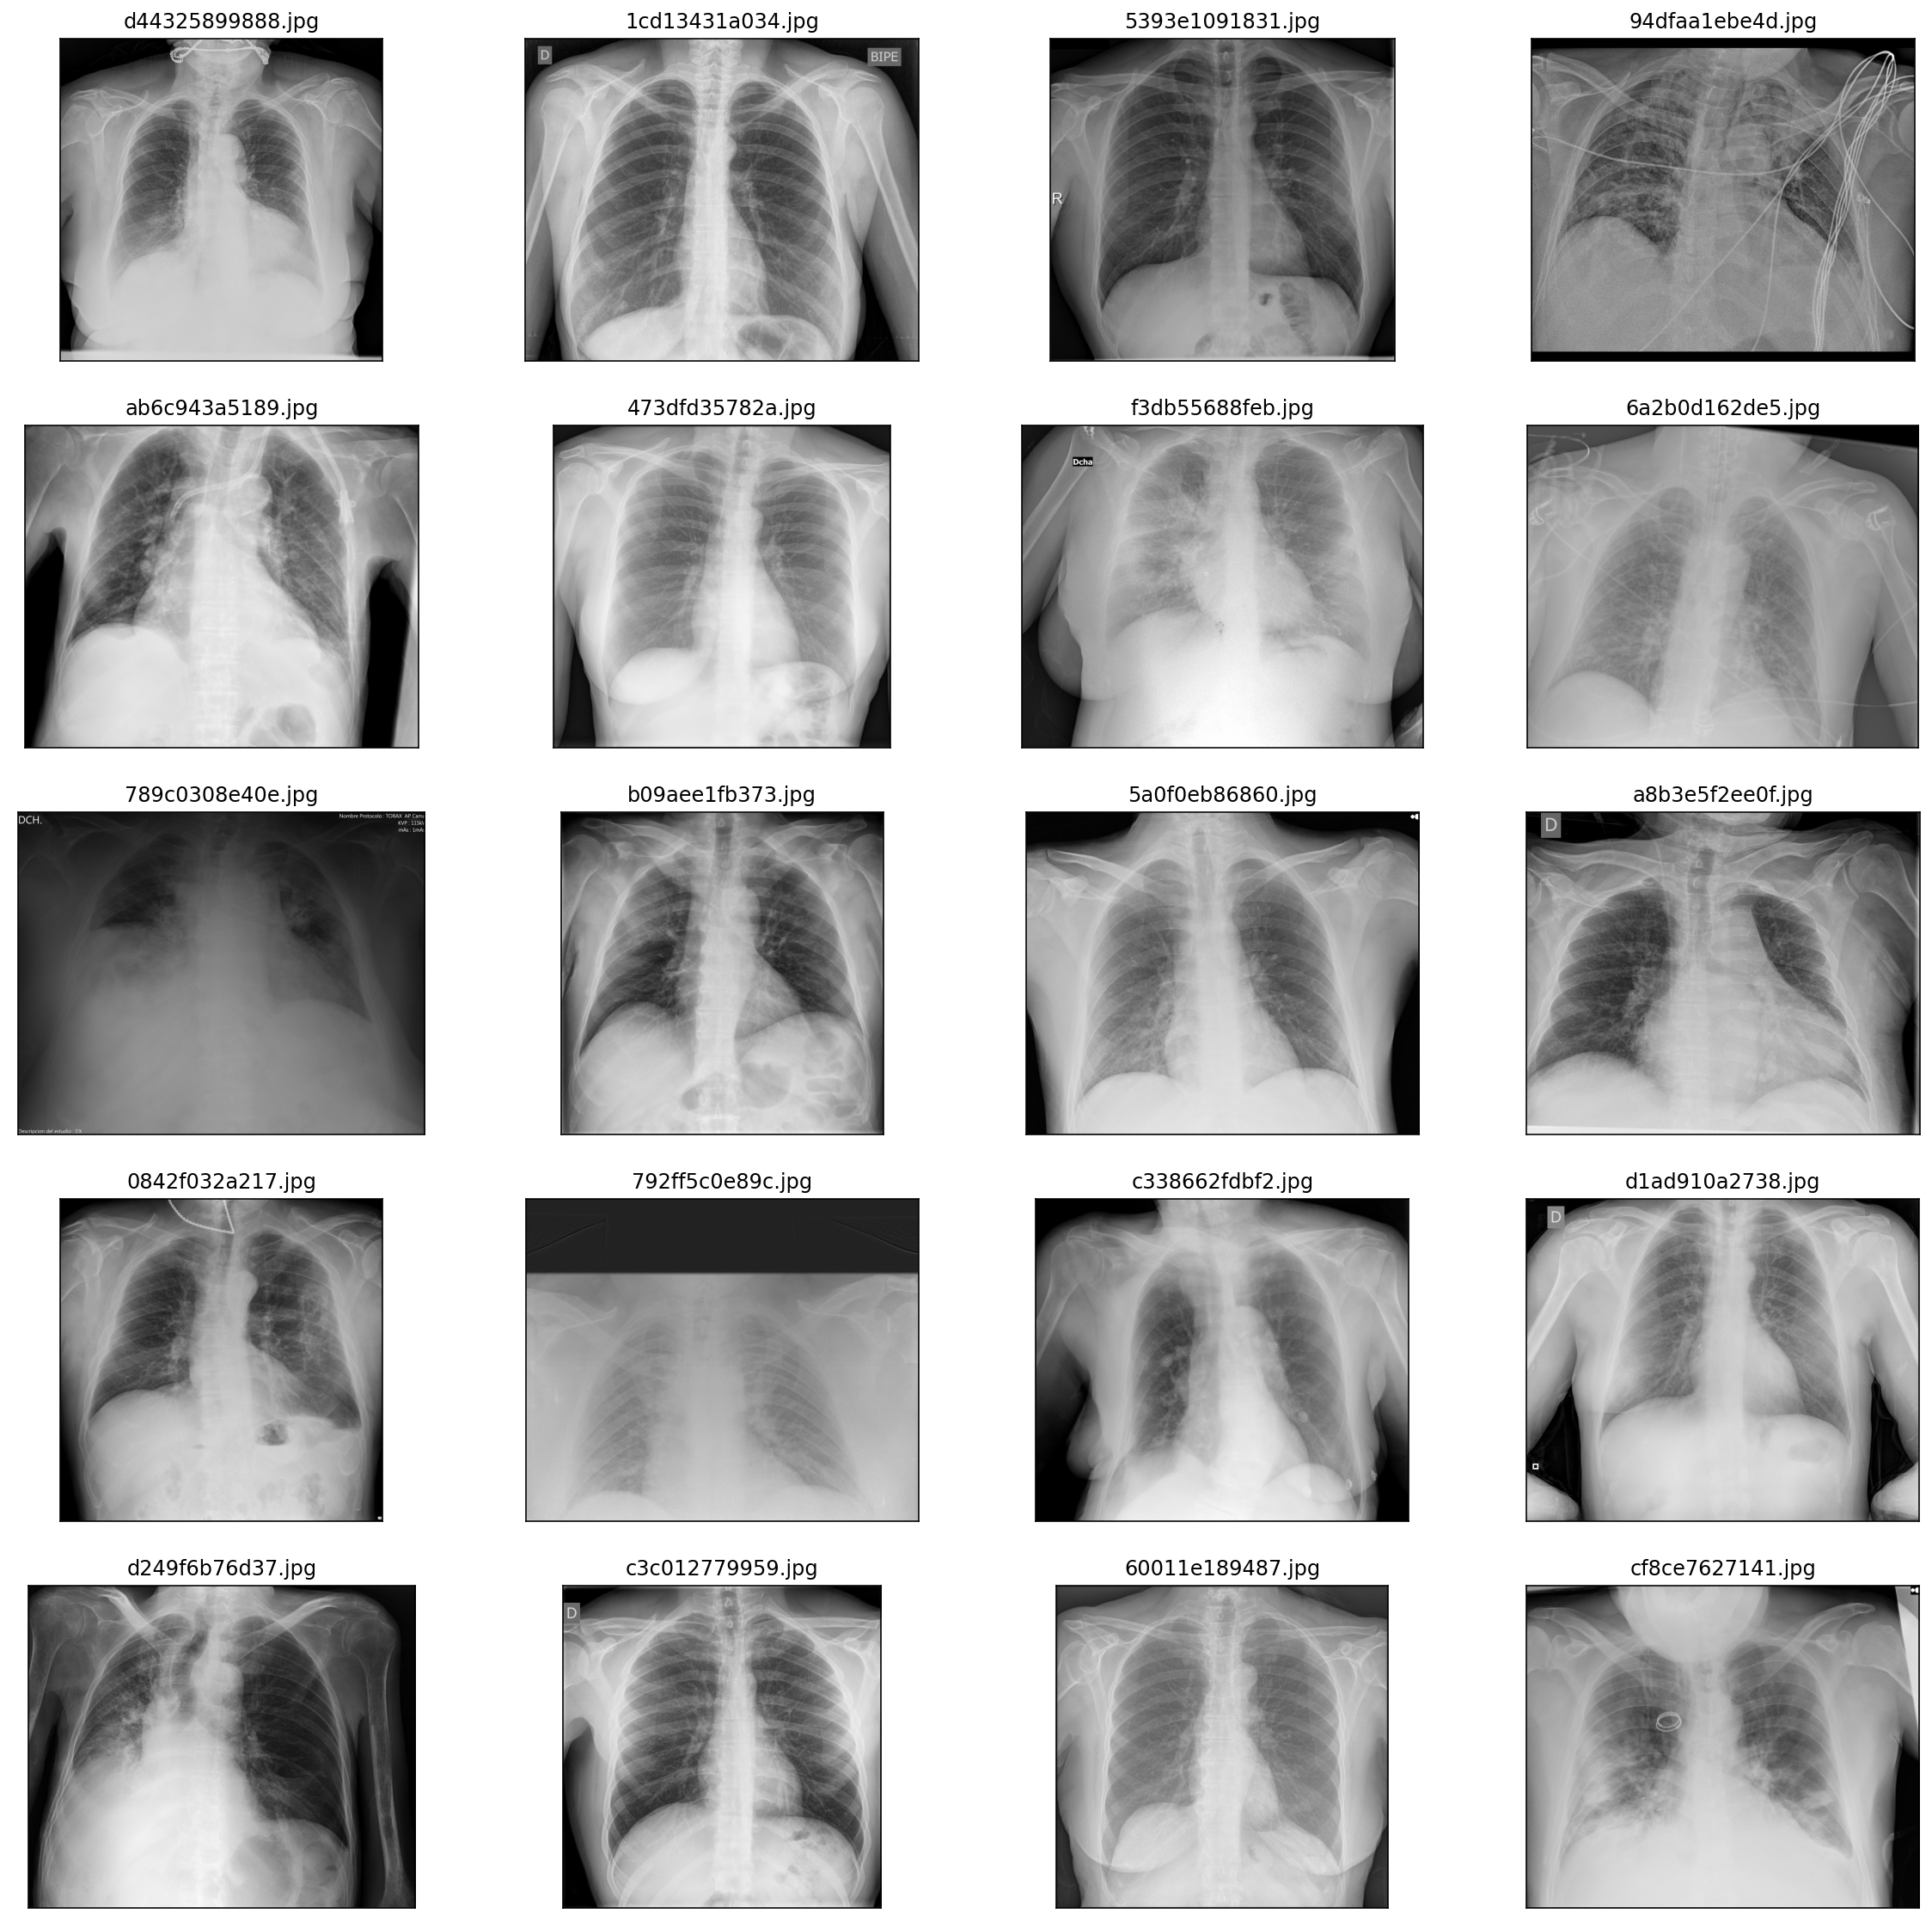

In [18]:
plt.figure(figsize=(20, 20))
l = []
for i in range(20):
    ix = np.random.randint(0, len(os.listdir("/app/_data/jpg/")))
    l.append(os.listdir("/app/_data/jpg/")[ix])
    j = Image.open("/app/_data/jpg/" + os.listdir("/app/_data/jpg/")[ix])
    plt.subplot(5, 4, i + 1)
    plt.title(os.listdir("/app/_data/jpg/")[ix])
    plt.imshow(j)
    plt.xticks([])
    plt.yticks([])
plt.show()